**The dataset used in this article is fairly clean already. Except for duplicates, missing values and outliers, there are no structural errors in features. As part for data preprocessing, the features will be given their proper names and proper data types. Similarly, for data cleaning, duplicates will be removed and outliers will be handled.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
# setting some styles and options
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# import the dataset
df = pd.read_csv("/kaggle/input/sydney-house-prices/SydneyHousePrices.csv")
df.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


In [4]:
# droping id column as it isn't needed anymore
df = df.drop('Id',axis='columns')

In [5]:
# Keeping target dependant feature 'sellPrice' to the right most column in the dataframe
target_feature = df.pop('sellPrice')
df.insert(len(df.columns),'sellPrice',target_feature)

df.head()

,Date,suburb,postalCode,bed,bath,car,propType,sellPrice
0,2019-06-19,Avalon Beach,2107,4.0,2,2.0,house,1210000
1,2019-06-13,Avalon Beach,2107,4.0,3,4.0,house,2250000
2,2019-06-07,Whale Beach,2107,3.0,3,2.0,house,2920000
3,2019-05-28,Avalon Beach,2107,3.0,1,2.0,house,1530000
4,2019-05-22,Whale Beach,2107,5.0,4,4.0,house,8000000


In [6]:
df.shape

(199504, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199504 entries, 0 to 199503
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        199504 non-null  object 
 1   suburb      199504 non-null  object 
 2   postalCode  199504 non-null  int64  
 3   bed         199350 non-null  float64
 4   bath        199504 non-null  int64  
 5   car         181353 non-null  float64
 6   propType    199504 non-null  object 
 7   sellPrice   199504 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 12.2+ MB


# Handling Duplicates

In [8]:
# Checking for duplicates
df[df.duplicated()].shape

(273, 8)

The data has several duplicates.

In [9]:
# Remove duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
# Checking again for duplicates
df[df.duplicated()].shape

(0, 8)

In [11]:
# Total entries in dataset after removing duplicates
df.shape

(199231, 8)

# Re-assigning names and dtypes

In [12]:
list(df.columns)

['Date', 'suburb', 'postalCode', 'bed', 'bath', 'car', 'propType', 'sellPrice']

In [13]:
# Giveing features their proper names
df = df.rename(columns={'bed':'bedrooms', 'bath':'bathrooms', 'car':'carParkingSpace', 'propType':'propertyType'})

In [14]:
list(df.columns)

['Date',
 'suburb',
 'postalCode',
 'bedrooms',
 'bathrooms',
 'carParkingSpace',
 'propertyType',
 'sellPrice']

In [15]:
# Coverting date feature to datetime64
df['Date'] = pd.to_datetime(df['Date'])

# Coverting cateogrical feature to category
df['suburb'] = df['suburb'].astype('category')
df['propertyType'] = df['propertyType'].astype('category')
df['postalCode'] = df['postalCode'].astype('category')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199231 entries, 0 to 199230
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             199231 non-null  datetime64[ns]
 1   suburb           199231 non-null  category      
 2   postalCode       199231 non-null  category      
 3   bedrooms         199078 non-null  float64       
 4   bathrooms        199231 non-null  int64         
 5   carParkingSpace  181113 non-null  float64       
 6   propertyType     199231 non-null  category      
 7   sellPrice        199231 non-null  int64         
dtypes: category(3), datetime64[ns](1), float64(2), int64(2)
memory usage: 8.6 MB


# Handling missing values

<Axes: >

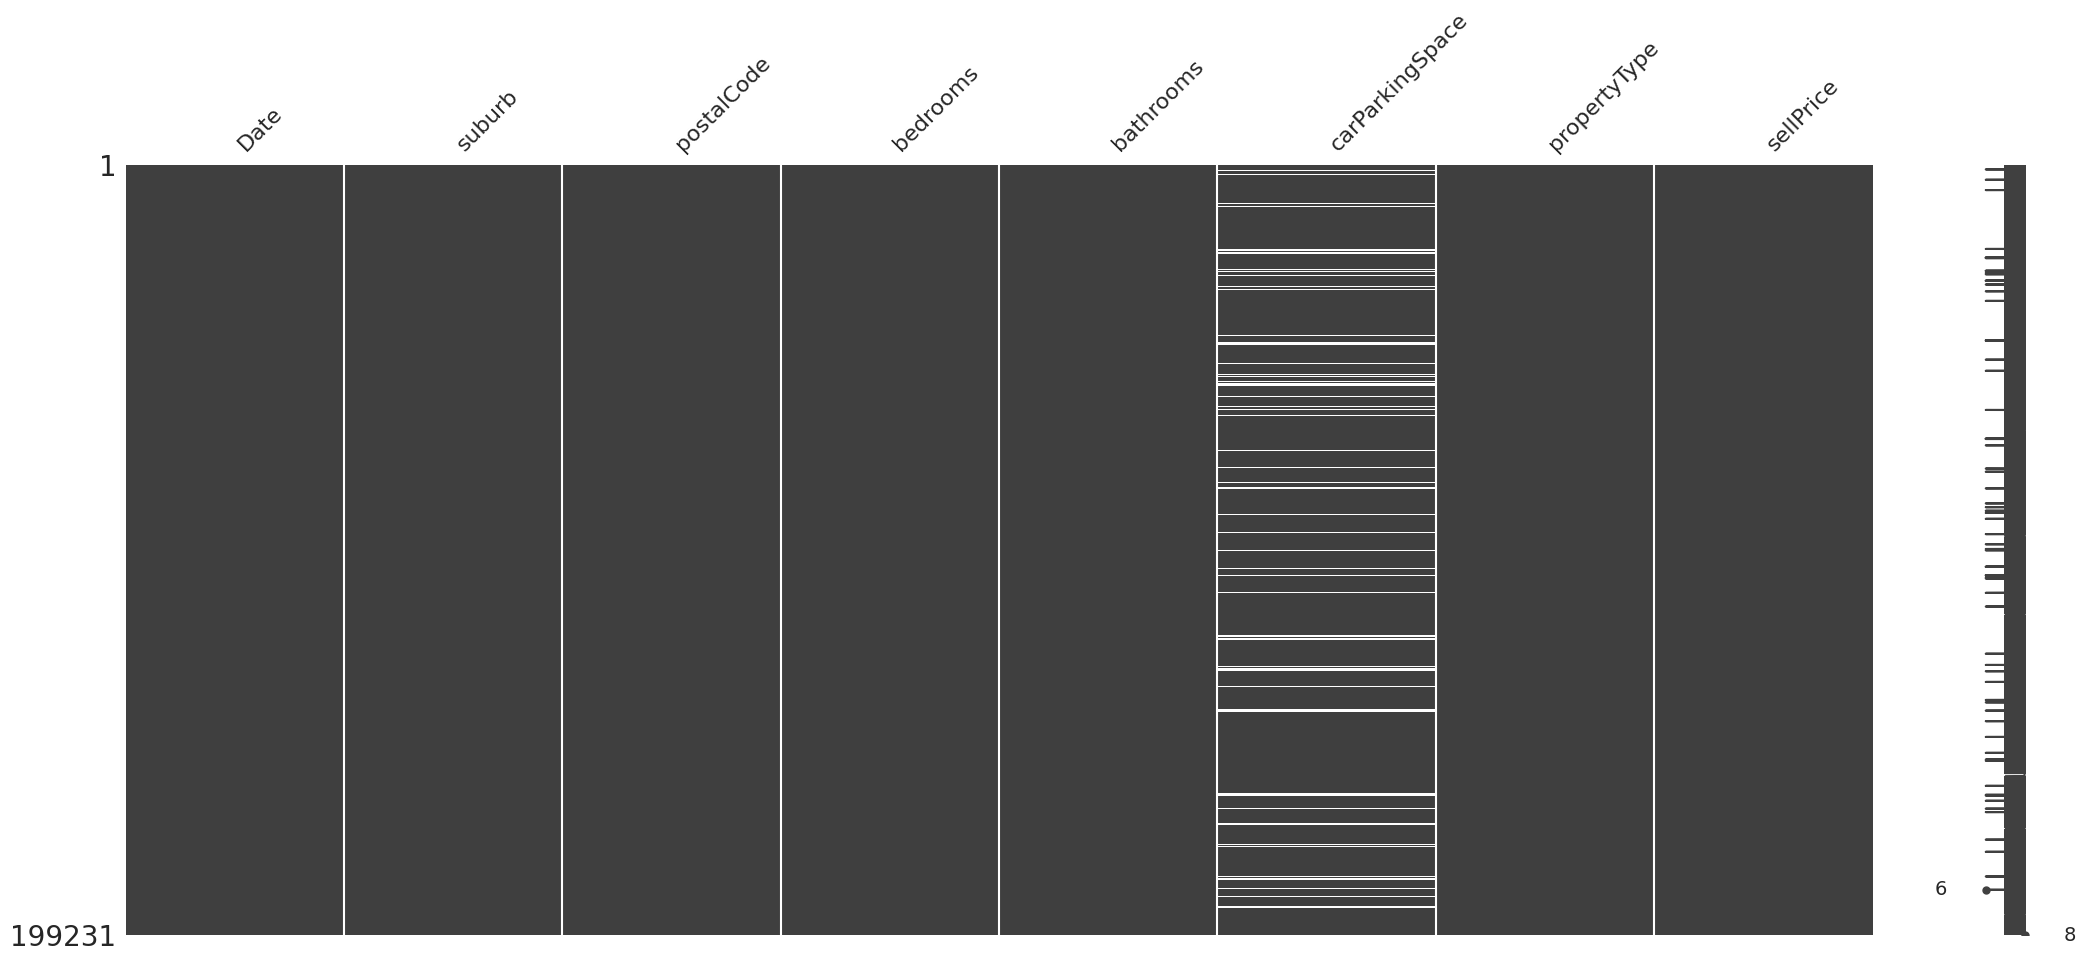

In [17]:
import missingno as msno
msno.matrix(df)

In [18]:
(df.isnull().sum() / df.shape[0]) * 100 # coverting missing values into percentage

Date               0.000000
suburb             0.000000
postalCode         0.000000
bedrooms           0.076795
bathrooms          0.000000
carParkingSpace    9.093966
propertyType       0.000000
sellPrice          0.000000
dtype: float64

In [19]:
# Missing values in bed features
df[pd.isna(df['bedrooms'])].shape

(153, 8)

In [20]:
# Missing values in car feature
df[pd.isna(df['carParkingSpace'])].shape

(18118, 8)

* 'carParkingSpace' contains almost 9.1% missing values or 18,151 missing values.
* While, feature 'bedrooms' contains 154 missing values.

# Fixing 'bed' feature null values

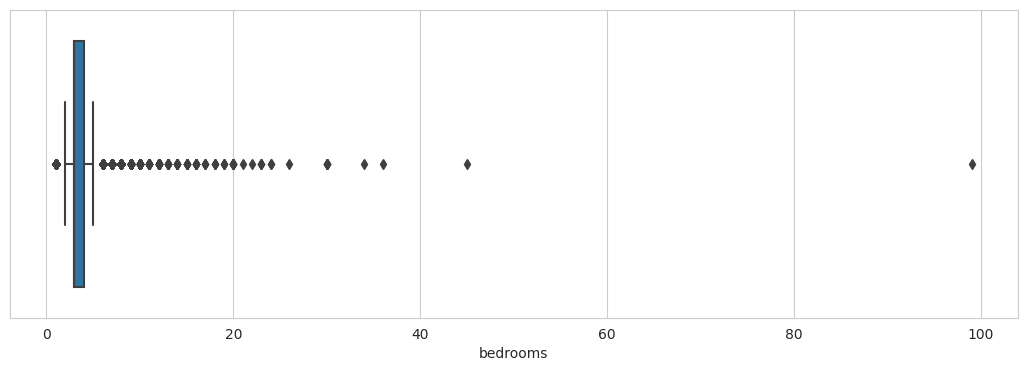

In [21]:
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='bedrooms')
plt.show()

**Since, 'bed' feature is skewed and has extreme values (outliers), it's better to use median to replace null values.**

In [22]:
# Replace null values of 'car' feature with its median
bed_median = df['bedrooms'].median()
df['bedrooms'].fillna(bed_median, inplace=True)

In [23]:
# Checking for null values in 'car' feature
df['bedrooms'].isnull().sum() / df['bedrooms'].shape[0]

0.0

We can see there is no null values now.

# Fixing 'car' feature null values

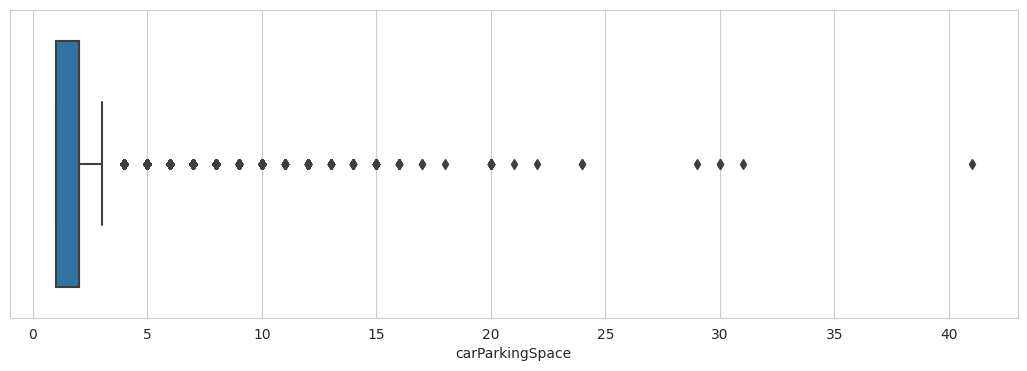

In [24]:
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x='carParkingSpace')
plt.show()

**Since, 'car' is also skewed, it is better to use median to replace the null values.**

In [25]:
# Replacing null values of 'car' feature with its median
bed_median = df['carParkingSpace'].median()
df['carParkingSpace'].fillna(bed_median, inplace=True)


In [26]:
# Checking for null values in 'car' feature
df['carParkingSpace'].isnull().sum() / df['carParkingSpace'].shape[0]

0.0

No null values.

# Checking data after handling missing values

In [27]:
# Displaying missing values
df.isnull().sum()

Date               0
suburb             0
postalCode         0
bedrooms           0
bathrooms          0
carParkingSpace    0
propertyType       0
sellPrice          0
dtype: int64

No missing values.

In [28]:
# Describing numeric features
df.describe()

,Date,bedrooms,bathrooms,carParkingSpace,sellPrice
count,199231,199231.000000,199231.000000,199231.000000,1.992310e+05
mean,2015-02-11 22:28:05.484688896,3.516099,1.890574,1.942298,1.270262e+06
min,2000-12-01 00:00:00,1.000000,1.000000,1.000000,1.000000e+00
25%,2013-05-04 00:00:00,3.000000,1.000000,1.000000,7.200000e+05
50%,2015-07-22 00:00:00,3.000000,2.000000,2.000000,9.860000e+05
75%,2017-05-29 00:00:00,4.000000,2.000000,2.000000,1.475000e+06
max,2019-07-06 00:00:00,99.000000,99.000000,41.000000,2.147484e+09
std,NaN,1.066395,0.926164,1.011262,6.952951e+06


In [29]:
# Describing non=numeric features
# pandas version <v1.5 see here -> https://github.com/mlflow/mlflow/issues/7878#issuecomment-1439405009
df.describe(exclude=['int', 'float'])

,Date,suburb,postalCode,propertyType
count,199231,199231,199231.0,199231
unique,NaN,685,235.0,8
top,NaN,Castle Hill,2229.0,house
freq,NaN,1249,1250.0,169931
mean,2015-02-11 22:28:05.484688896,NaN,NaN,NaN
min,2000-12-01 00:00:00,NaN,NaN,NaN
25%,2013-05-04 00:00:00,NaN,NaN,NaN
50%,2015-07-22 00:00:00,NaN,NaN,NaN
75%,2017-05-29 00:00:00,NaN,NaN,NaN
max,2019-07-06 00:00:00,NaN,NaN,NaN


In [30]:
pd.__version__

'2.0.3'

The dataset contains record of 199231 properties sold from 1 December, 2000 to 6 July,2019

# Feature Engineering

'Date' feature is in YYYY-MM-DD format. For analysis purpose, 'Date' feature will be transformered into 3 new features: years, months, and day.

In [31]:
list(df.columns)

['Date',
 'suburb',
 'postalCode',
 'bedrooms',
 'bathrooms',
 'carParkingSpace',
 'propertyType',
 'sellPrice']

In [32]:
import calendar
month_names = [calendar.month_name[i] for i in range(1,13)]

# extracting year, month, and day as separate columns
year = df['Date'].dt.year
month = df['Date'].dt.month.apply(lambda x: month_names[x-1])
day = df['Date'].dt.day

# Inserting new year, month, and day features
df.insert(1, 'dayOfMonth', day)
df.insert(1, 'monthOfYear', month)
df.insert(1, 'yearSold', year)

In [33]:
# Assigning category data ype to the month feature
df['monthOfYear'] = df['monthOfYear'].astype('category')

In [34]:
df = df.drop('Date', axis=1) # Removing Date feature

df.head()

,yearSold,monthOfYear,dayOfMonth,suburb,postalCode,bedrooms,bathrooms,carParkingSpace,propertyType,sellPrice
0,2019,June,19,Avalon Beach,2107,4.0,2,2.0,house,1210000
1,2019,June,13,Avalon Beach,2107,4.0,3,4.0,house,2250000
2,2019,June,7,Whale Beach,2107,3.0,3,2.0,house,2920000
3,2019,May,28,Avalon Beach,2107,3.0,1,2.0,house,1530000
4,2019,May,22,Whale Beach,2107,5.0,4,4.0,house,8000000


# Handling outliers

Handling outliers is ver important as presence of outliers can affect the analysis, correlation, and modeling results in a significant way. Outliers are extreme values that are much higher or lower than other values in the dataset.

In [35]:
def plotter(plot_name, dataframe, feature, figsize_width, figsize_height):
    """
    This function can display different plots based on the parameters given. 
    """
    plt.figure(figsize=(figsize_width, figsize_height))
    if plot_name == 'boxplot':
        sns.boxplot(data=dataframe, x=feature)
    elif plot_name == 'kdeplot':
        sns.kdeplot(dataframe[feature], bw_adjust=0.2)
    plt.show()
    
def remove_outliers(dataframe, feature, conditional=">", value=0, testing=False):
    """
    If testing=False, removes any outliers below or above "conditional" certain given 'value' and prints report of how many outliers removed.
    if testing=True, prints report of howmany outliers detected, and displays a box plot whichdepicts how data will be if detected outliers are removed.
    """
    if conditional==">":
        # Filtering out the outliers
        outliers = dataframe.loc[dataframe[feature]>value]
    elif conditional=="<":
        # Filtering out the outliers
        outliers = dataframe.loc[dataframe[feature]<value]
    # Removing the obvious outliers
    outliers_index = outliers.index
    if testing==False:
        dataframe.drop(outliers_index, inplace=True)
        print(f"{len(outliers_index)} outliers removed.")
    elif testing==True:
        print(f"{len(outliers_index)} outliers detected. If those outliers are removed, the distributton would be as given below:")
        new_df = dataframe.copy()
        new_df.drop(outliers_index, inplace=True)
        plotter('boxplot', new_df, feature, 13,4)
        
def remove_given_indexes(dataframe, indexes=[]):
    # Remove the entries corresponding to the indices in the list
    dataframe.drop(index=indexes, inplace=True)
    print(f"Entries {str(indexes)} removed.")
    
def print_outliers(dataframe, feature, conditional=">", value=0):
    if conditional == ">":
        # Filtering out the outliers
        outliers = dataframe.loc[dataframe[feature]>value]
    elif conditional=="<":
        # Filtering out the outliers
        outliers = dataframe.loc[dataframe[feature]<value]
    return outliers

In [36]:
def outliers_checker_based_on_quantiles(feature, dataframe):
    """
    Checks if any outliers are present above 90th percetile and 10th percentile
    """
    # Using 10th and 90th quartile
    tenth_quantile = dataframe[feature].quantile(0.10)
    ninetieth_quantile = dataframe[feature].quantile(0.90)
    
    lower_outliers = dataframe.loc[df[feature]<tenth_quantile]
    upper_outliers = dataframe.loc[df[feature]>ninetieth_quantile]
    
    
    # Using Inter Quartile Range
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    
    Iqr_lower_outliers = dataframe.loc[dataframe[feature] < lower_limit]
    Iqr_upper_outliers = dataframe.loc[dataframe[feature] > upper_limit]
    
    print(f"The feature '{feature}' has {lower_outliers.shape[0]} outliers below 10th quartile and {upper_outliers.shape[0]} outliers above 90th quartile.")
    print(f"Similarly, according to IQR limits, the feature '{feature}' has {Iqr_lower_outliers.shape[0]} outliers below lower limit and {Iqr_upper_outliers.shape[0]} outliers above upper limit.")
    

# Handling outliers in 'sellPrice'

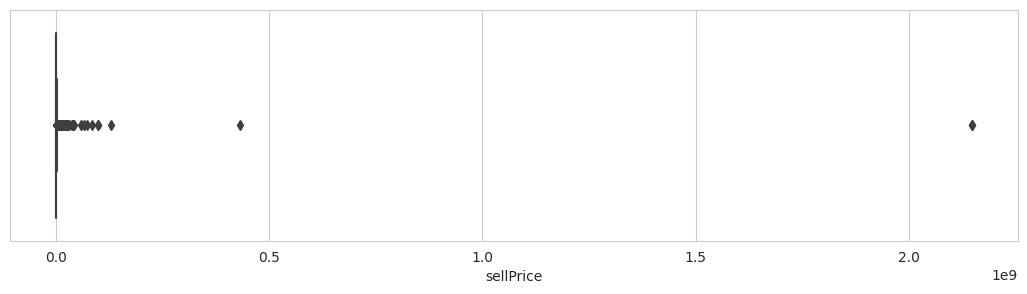

In [37]:
# Plotting boxplot before making any changes
plotter('boxplot', df, 'sellPrice', 13,3)

The way extreme outliers are probably entry error. So, it should be removed.

3 outliers removed.


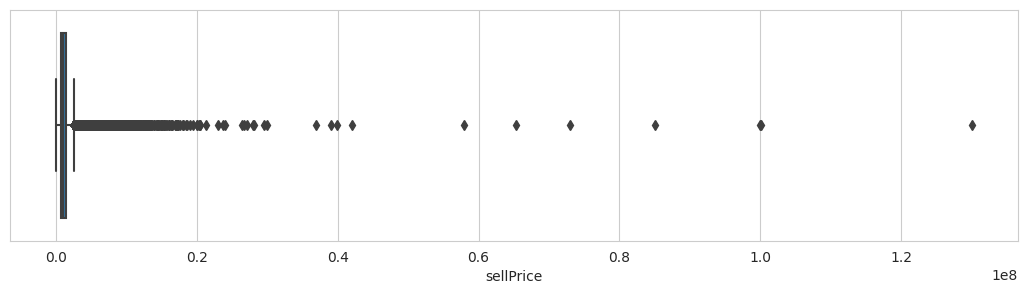

In [38]:
remove_outliers(df, 'sellPrice', '>', 0.35e9, testing = False)

plotter('boxplot', df, 'sellPrice', 13,3)

11 outliers detected. If those outliers are removed, the distributton would be as given below:


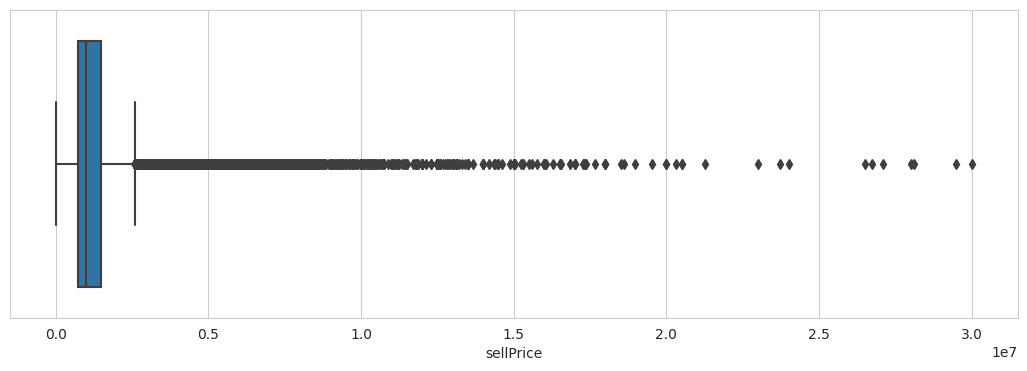

,yearSold,monthOfYear,dayOfMonth,suburb,postalCode,bedrooms,bathrooms,carParkingSpace,propertyType,sellPrice
48621,2015,May,20,Point Piper,2027,5.0,5,7.0,house,39900000
48713,2014,October,7,Point Piper,2027,6.0,8,6.0,house,39000000
48717,2014,June,11,Point Piper,2027,5.0,7,4.0,house,37000000
77288,2014,February,22,Sylvania,2224,5.0,3,2.0,house,130000000
103736,2014,May,19,Merrylands,2160,3.0,1,2.0,other,73000000
120263,2009,April,16,Beverly Hills,2209,4.0,3,2.0,house,100000000
121659,2014,April,8,Glenmore Park,2745,5.0,5,2.0,house,100050000
127505,2017,December,15,Vaucluse,2030,6.0,6,3.0,house,65250000
131815,2013,December,10,Miranda,2228,4.0,2,1.0,other,85000000
191498,2014,January,11,Winmalee,2777,3.0,2,2.0,house,42000000


In [39]:
# Checking other remaining outliers to see if there are any noticable abnormalities
# to note their indexes and remove them
remove_outliers(df, 'sellPrice', '>', 0.35e8, testing = True)

print_outliers(df, 'sellPrice', '>', 0.35e8)

Looking at the features of index entry number'103736', the price seems abnormal. It should be removed.

In [40]:
remove_given_indexes(df, [103736])

Entries [103736] removed.


In [41]:
outliers_checker_based_on_quantiles('sellPrice', df)

The feature 'sellPrice' has 19697 outliers below 10th quartile and 19917 outliers above 90th quartile.
Similarly, according to IQR limits, the feature 'sellPrice' has 0 outliers below lower limit and 11548 outliers above upper limit.


# Handling outliers in 'yearSold'

In [42]:
def numeric_histplot_and_boxplot_plotter(feature, fig_width, fig_height):
    if df[feature].dtype == 'int32' or df[feature].dtype == 'float64':
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(fig_width, fig_height))
        
        sns.scatterplot(data=df, x=feature, y='sellPrice', ax=ax1).set_title('Width respect to Selling Prices')
        
        sns.boxplot(data=df, x=feature, ax=ax2).set_title('With respect to counts')
        
        plt.tight_layout()
        plt.show()
        
        
    else:
        print('Provide a numeric feature')

In [43]:
df['yearSold'].value_counts()

yearSold
2017    27977
2015    26195
2016    26149
2018    23565
2014    22961
2013    17745
2012    11918
2011    10510
2010     9398
2019     9373
2009     8249
2008     3927
2007      824
2006      195
2005      150
2004       63
2003       15
2001        9
2002        3
2000        1
Name: count, dtype: int64

Years 2000 to 2003 have very number of entries. It is better to remove them.

In [44]:
df = df.loc[(df['yearSold'] > 2003)]

df['yearSold'].value_counts()

yearSold
2017    27977
2015    26195
2016    26149
2018    23565
2014    22961
2013    17745
2012    11918
2011    10510
2010     9398
2019     9373
2009     8249
2008     3927
2007      824
2006      195
2005      150
2004       63
Name: count, dtype: int64

In [45]:
outliers_checker_based_on_quantiles('yearSold',df)

The feature 'yearSold' has 13408 outliers below 10th quartile and 9373 outliers above 90th quartile.
Similarly, according to IQR limits, the feature 'yearSold' has 408 outliers below lower limit and 0 outliers above upper limit.


In [46]:
df['yearSold'].dtype

dtype('int32')

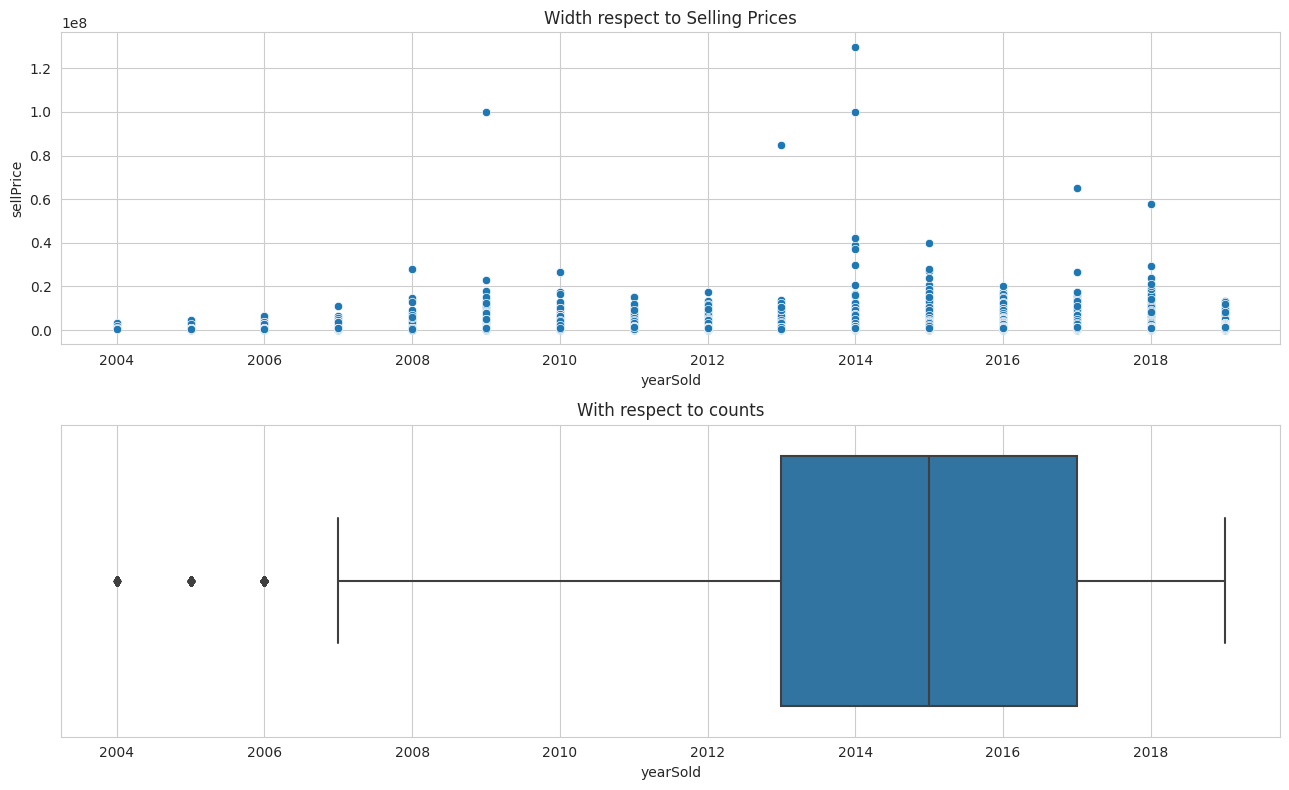

In [47]:
numeric_histplot_and_boxplot_plotter('yearSold', 13, 8)

We can clearly see in above 'With respect to selling price' figure, that there still are some potential outliers.

In [48]:
# filtering out the outliers

outliers_yearSold = df.loc[(df['yearSold'].isin([2009,2013,2014,2017,2018])) & (df['sellPrice']>0.5e8)]
outliers_yearSold

,yearSold,monthOfYear,dayOfMonth,suburb,postalCode,bedrooms,bathrooms,carParkingSpace,propertyType,sellPrice
77288,2014,February,22,Sylvania,2224,5.0,3,2.0,house,130000000
120263,2009,April,16,Beverly Hills,2209,4.0,3,2.0,house,100000000
121659,2014,April,8,Glenmore Park,2745,5.0,5,2.0,house,100050000
127505,2017,December,15,Vaucluse,2030,6.0,6,3.0,house,65250000
131815,2013,December,10,Miranda,2228,4.0,2,1.0,other,85000000
193234,2018,August,27,Bellevue Hill,2023,5.0,6,8.0,house,58000000


These all seem way overpriced. It is better to remove them.

In [49]:
# Removing entries with given index
df = df.drop(outliers_yearSold.index)

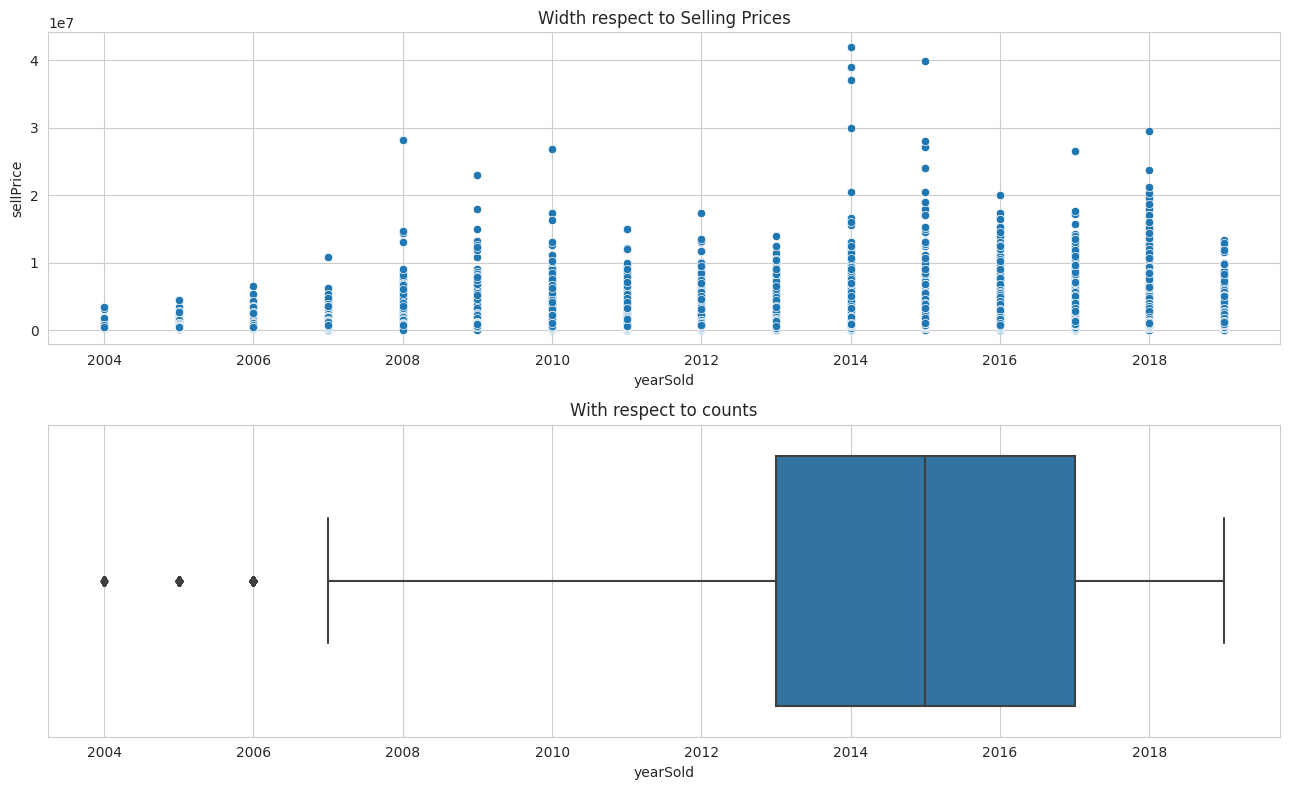

In [50]:
numeric_histplot_and_boxplot_plotter('yearSold', 13, 8)

# Handling outliers in 'dayOfMonth'